# Transformation Interpolations:  SDSS DR13 <--> GAIA EDR3

_Douglas L. Tucker_

_2022.07.2_

## Initial Setup

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp
import healpixTools

import extinction

import paramFile

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [2]:
# GAIA-->SDSS (toSDSS=True) or SDSS-->GAIA (toSDSS=False)...
#toSDSS = True
toSDSS = False


if toSDSS:
    # List of SDSS bands on which to run the transform fit...
    bandList = ['g_sdss', 'r_sdss', 'i_sdss', 'z_sdss', 'Y_sdss']
    # If GAIA-->SDSS, then the mag and color to fit against are GAIA...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_sdss':'G_gaia', 'r_sdss':'G_gaia', 'i_sdss':'G_gaia', 'z_sdss':'G_gaia', 'Y_sdss':'G_gaia'}
    # Color to fit against...
    color_name_1_dict = {'g_sdss':'BP_RP_gaia', 'r_sdss':'BP_RP_gaia', 'i_sdss':'BP_RP_gaia', 'z_sdss':'BP_RP_gaia', 'Y_sdss':'BP_RP_gaia'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_sdss':'$(BP-RP)$', 'r_sdss':'$(BP-RP)$', 'i_sdss':'$(BP-RP)$', 'z_sdss':'$(BP-RP)$', 'Y_sdss':'$(BP-RP)$'}

else:    
    # List of GAIA bands on which to run the transform fit...
    bandList = ['G_gaia']
    # If SDSS-->GAIA, then the mag and color to fit against are SDSS...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'G_gaia':'i_sdss'}
    # Color to fit against...
    color_name_1_dict = {'G_gaia':'gi_sdss'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'G_gaia':'$(g-i)_{sdss}$'}


# Size of the binsize in color
color_binsize = 0.10

# Identify directory containing the SDSS/Stetson match file...
matchDir = './'

# Name of the DES/SDSS/GaiaEDR3 match file in matchDir
matchFile = 'match_y6a2_stripe82area_stars_GAIAedr3_SDSSDR13.fits'


# Base name of fit results output file...
if toSDSS:
    resultsFileBaseName = 'transInterp.gaia_to_sdss'
else:
    resultsFileBaseName = 'transInterp.sdss_to_gaia'

# Base name of QA plot output files...
if toSDSS:
    qaFileBaseName = 'qaPlot.gaia_to_sdss.interp'
else:
    qaFileBaseName = 'qaPlot.sdss_to_gaia.interp'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


## Define Some Modules

In [3]:
# From Zeljko Ivezic:
# Robust estimate of standard deviation: 0.741*(q75-q25)
#  sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
# Uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
#  sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])

def robustStdDev(data):
    sd = 0.741*(np.percentile(data,75)-np.percentile(data,25))
    return sd

def uncMedian(data, npts):
    sd = robustStdDev(data)
    uncMedian = np.sqrt(np.pi/2)*sd/np.sqrt(npts)
    return uncMedian

In [4]:
##################################

def interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                         title, dmagLabel, outputFileName, verbose):

        
    # Create linear interpolation of the median dmag vs. color bin calculated above...
    response = interpolate.interp1d(df1.index.values.astype(float), df1.bin_median.values, \
                                bounds_error=False, fill_value=0., kind='linear')    

    # Calculate and apply the offset for the individual stars in df, 
    #  based on the linear interpolation calculated above...
    df['offset'] = response(df[color_name_1].values)    
    df['res'] = df['dmag'] - df['offset']    
    if verbose>1:
        print 
        print df[[color_name_1, 'offset', 'res']].head()
        print 

    # Calculate the 'robust' RMS of the residuals....
    rms = robustStdDev(df['res'].values)


    # Identify range to plot in the dmag (Y-axis) direction...
    dmag_desc = df['dmag'].describe(percentiles=[0.001, 0.999])
    if verbose>1:
        print dmag_desc
    dmag_min = math.floor(10*dmag_desc['0.1%'])/10.
    dmag_max = math.ceil(10*dmag_desc['99.9%'])/10.

    dmag_mask = (df['dmag'] >= dmag_min) & (df['dmag'] <= dmag_max)
    df_dmag_mask = df[dmag_mask]
    

    # Identify range to plot in the residuals (Y-axis) direction...
    res_desc = df['res'].describe(percentiles=[0.01, 0.99])
    if verbose>1:
        print 
        print res_desc
        print 
    #res_min = math.floor(10*dmag_desc['1%'])/10.
    #res_max = math.ceil(10*dmag_desc['99%'])/10.
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    res_min = -0.10
    res_max = +0.10


    # For 2d binning below, we mask df for just those stars within 
    #  the res_min, res_max range...
    res_mask = (df['res'] >= res_min) & (df['res'] <= res_max)
    df_res_mask = df[res_mask]
    
    
    # Prepare QA plots...
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    
    # Modify matplotlib font...
    #font = {'family' : 'normal',
    #        'weight' : 'bold',
    #       'size'   : 22}
    #matplotlib.rc('font', **font)    
    plt.rcParams.update({'font.size': 24})

    
    ## Include a supertitle to the matplotlob figure...
    #fig.suptitle('This is the superTitle')

    
    # Plot 1:  Descriptive text...
    plt.subplot(221)
    plot1Text = """%s \n\n\n\n%s vs. %s\n\n[rms: %.3f] \n\n[%.1f < %s < %.1f]""" % \
                    (title, dmagLabel, colorLabel_1, rms, color1_min, colorLabel_1, color1_max)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(222)
    hb=plt.hexbin(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, \
                      gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel(dmagLabel)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)
    # Overplot the binned values calculated above:
    plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, fmt='o')

    
    # Plot 3:  1d histogram of residuals...
    plt.subplot(223) 
    plt.hist(df_res_mask.loc[:,'res'],bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.xlim([res_min, res_max])
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(224) 
    hb=plt.hexbin(df_res_mask.loc[:, color_name_1].values, df_res_mask.loc[:,'res'].values, \
                  gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel('Residuals')
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)
    
    
    # Plot...
    plt.tight_layout()
    

    # Save QA plots to file...
    plt.savefig(outputFileName)    
    

    return 0


##################################

## Read in Matched Catalog

In [5]:
matchFile = os.path.join(matchDir,matchFile)
print matchFile

./match_y6a2_stripe82area_stars_GAIAedr3_SDSSDR13.fits


In [6]:
# Check to make sure matchFile exists...
if os.path.isfile(matchFile)==False:
    print """ERROR:  matchFile %s does not exist...""" % (matchFile)
if verbose > 0:
    print 'matchFile: ', matchFile


matchFile:  ./match_y6a2_stripe82area_stars_GAIAedr3_SDSSDR13.fits


In [7]:
tab = Table.read(matchFile, format='fits')
tab

COADD_OBJECT_ID_1,RA,DEC,ALPHAWIN_J2000_1,DELTAWIN_J2000_1,PFW_ATTEMPT_ID_1,OBJECT_NUMBER_1,PARENT_NUMBER_1,TILENAME_1,L_1,B_1,EBV_SFD98_1,HPIX_32_1,HPIX_64_1,HPIX_1024_1,HPIX_4096_1,HPIX_16384_1,KRON_RADIUS_1,A_IMAGE_1,B_IMAGE_1,THETA_J2000_1,ERRA_IMAGE_1,ERRB_IMAGE_1,ERRTHETA_IMAGE_1,XWIN_IMAGE_1,YWIN_IMAGE_1,MAG_DETMODEL_G_1,MAG_AUTO_G_1,MAG_APER_8_G_1,WAVG_MAG_PSF_G_1,MAGERR_DETMODEL_G_1,MAGERR_AUTO_G_1,MAGERR_APER_8_G_1,WAVG_MAGERR_PSF_G_1,FLUX_DETMODEL_G_1,FLUX_AUTO_G_1,WAVG_FLUX_PSF_G_1,FLUX_RADIUS_G_1,FLUX_APER_8_G_1,FLUXERR_DETMODEL_G_1,FLUXERR_AUTO_G_1,WAVG_FLUXERR_PSF_G_1,FLUXERR_APER_8_G_1,MU_EFF_MODEL_G_1,MU_MAX_G_1,MU_MAX_MODEL_G_1,MU_MEAN_MODEL_G_1,MU_THRESHOLD_G_1,SPREADERR_MODEL_G_1,SPREAD_MODEL_G_1,CLASS_STAR_G_1,NITER_MODEL_G_1,WAVG_SPREADERR_MODEL_G_1,WAVG_SPREAD_MODEL_G_1,FLAGS_G_1,IMAFLAGS_ISO_G_1,NEPOCHS_G_1,MOLY_NUMBER_G_1,MAG_DETMODEL_R_1,MAG_AUTO_R_1,MAG_APER_8_R_1,WAVG_MAG_PSF_R_1,MAGERR_DETMODEL_R_1,MAGERR_AUTO_R_1,MAGERR_APER_8_R_1,WAVG_MAGERR_PSF_R_1,FLUX_DETMODEL_R_1,FLUX_AUTO_R_1,WAVG_FLUX_PSF_R_1,FLUX_RADIUS_R_1,FLUX_APER_8_R_1,FLUXERR_DETMODEL_R_1,FLUXERR_AUTO_R_1,WAVG_FLUXERR_PSF_R_1,FLUXERR_APER_8_R_1,MU_EFF_MODEL_R_1,MU_MAX_R_1,MU_MAX_MODEL_R_1,MU_MEAN_MODEL_R_1,MU_THRESHOLD_R_1,SPREADERR_MODEL_R_1,SPREAD_MODEL_R_1,CLASS_STAR_R_1,NITER_MODEL_R_1,WAVG_SPREADERR_MODEL_R_1,WAVG_SPREAD_MODEL_R_1,FLAGS_R_1,IMAFLAGS_ISO_R_1,NEPOCHS_R_1,MOLY_NUMBER_R_1,MAG_DETMODEL_I_1,MAG_AUTO_I_1,MAG_APER_8_I_1,WAVG_MAG_PSF_I_1,MAGERR_DETMODEL_I_1,MAGERR_AUTO_I_1,MAGERR_APER_8_I_1,WAVG_MAGERR_PSF_I_1,FLUX_DETMODEL_I_1,FLUX_AUTO_I_1,WAVG_FLUX_PSF_I_1,FLUX_RADIUS_I_1,FLUX_APER_8_I_1,FLUXERR_DETMODEL_I_1,FLUXERR_AUTO_I_1,WAVG_FLUXERR_PSF_I_1,FLUXERR_APER_8_I_1,MU_EFF_MODEL_I_1,MU_MAX_I_1,MU_MAX_MODEL_I_1,MU_MEAN_MODEL_I_1,MU_THRESHOLD_I_1,SPREADERR_MODEL_I_1,SPREAD_MODEL_I_1,CLASS_STAR_I_1,NITER_MODEL_I_1,WAVG_SPREADERR_MODEL_I_1,WAVG_SPREAD_MODEL_I_1,FLAGS_I_1,IMAFLAGS_ISO_I_1,NEPOCHS_I_1,MOLY_NUMBER_I_1,MAG_DETMODEL_Z_1,MAG_AUTO_Z_1,MAG_APER_8_Z_1,WAVG_MAG_PSF_Z_1,MAGERR_DETMODEL_Z_1,MAGERR_AUTO_Z_1,MAGERR_APER_8_Z_1,WAVG_MAGERR_PSF_Z_1,FLUX_DETMODEL_Z_1,FLUX_AUTO_Z_1,WAVG_FLUX_PSF_Z_1,FLUX_RADIUS_Z_1,FLUX_APER_8_Z_1,FLUXERR_DETMODEL_Z_1,FLUXERR_AUTO_Z_1,WAVG_FLUXERR_PSF_Z_1,FLUXERR_APER_8_Z_1,MU_EFF_MODEL_Z_1,MU_MAX_Z_1,MU_MAX_MODEL_Z_1,MU_MEAN_MODEL_Z_1,MU_THRESHOLD_Z_1,SPREADERR_MODEL_Z_1,SPREAD_MODEL_Z_1,CLASS_STAR_Z_1,NITER_MODEL_Z_1,WAVG_SPREADERR_MODEL_Z_1,WAVG_SPREAD_MODEL_Z_1,FLAGS_Z_1,IMAFLAGS_ISO_Z_1,NEPOCHS_Z_1,MOLY_NUMBER_Z_1,MAG_DETMODEL_Y_1,MAG_AUTO_Y_1,MAG_APER_8_Y_1,WAVG_MAG_PSF_Y_1,MAGERR_DETMODEL_Y_1,MAGERR_AUTO_Y_1,MAGERR_APER_8_Y_1,WAVG_MAGERR_PSF_Y_1,FLUX_DETMODEL_Y_1,FLUX_AUTO_Y_1,WAVG_FLUX_PSF_Y_1,FLUX_RADIUS_Y_1,FLUX_APER_8_Y_1,FLUXERR_DETMODEL_Y_1,FLUXERR_AUTO_Y_1,WAVG_FLUXERR_PSF_Y_1,FLUXERR_APER_8_Y_1,MU_EFF_MODEL_Y_1,MU_MAX_Y_1,MU_MAX_MODEL_Y_1,MU_MEAN_MODEL_Y_1,MU_THRESHOLD_Y_1,SPREADERR_MODEL_Y_1,SPREAD_MODEL_Y_1,CLASS_STAR_Y_1,NITER_MODEL_Y_1,WAVG_SPREADERR_MODEL_Y_1,WAVG_SPREAD_MODEL_Y_1,FLAGS_Y_1,IMAFLAGS_ISO_Y_1,NEPOCHS_Y_1,MOLY_NUMBER_Y_1,ra_x,dec_x,errHalfMaj,errHalfMin,errPosAng,source_id,ra_error,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,pseudocolour,pseudocolour_error,visibility_periods_used,ruwe,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,panstarrs1,sdssdr13,skymapper2,urat1,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000,dec_epoch2000,ra_epoch2000_error,dec_epoch2000_error,r

In [8]:
df = tab.to_pandas()
df

,COADD_OBJECT_ID_1,RA,DEC,ALPHAWIN_J2000_1,DELTAWIN_J2000_1,PFW_ATTEMPT_ID_1,OBJECT_NUMBER_1,PARENT_NUMBER_1,TILENAME_1,L_1,...,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,Separation
0,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.352320,18.197308,0.105668,0.017967,0.016583,0.023540,0.027509,6361.0,1188.0,0.072306
1,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.273417,16.676876,0.189597,0.026167,0.015462,0.021712,0.017184,7778.0,83.0,0.131657
2,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,16.957182,16.818913,0.028147,0.018261,0.025981,0.018688,0.016255,7717.0,81.0,0.081412
3,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,18.321367,18.298330,0.039136,0.023591,0.014854,0.019058,0.027282,4263.0,82.0,0.147025
4,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,16.302778,16.103003,0.041825,0.020095,0.013199,0.018106,0.014031,2662.0,82.0,0.153573
5,1.034175e+09,0.000446,-4.093737,0.000446,-4.093737,2765741.0,54158.0,57212.0,DES0000-0416,92.631699,...,16.801933,16.655245,0.036887,0.025139,0.016387,0.013504,0.019310,6372.0,1188.0,0.167864
6,1.033052e+09,0.000603,2.368938,0.000603,2.368938,2763744.0,59148.0,63542.0,DES0000+0209,98.119377,...,18.253973,17.978533,0.194086,0.022775,0.022852,0.024477,0.028400,7712.0,81.0,0.101826
7,1.032398e+09,0.000712,-3.137557,0.000712,-3.137557,2764753.0,6582.0,6535.0,DES0000-0250,93.581673,...,16.352743,15.775401,0.155956,0.028578,0.017661,0.022097,0.017449,7907.0,83.0,0.166721
8,1.031851e+09,0.000722,-1.804559,0.000722,-1.804559,2758897.0,63615.0,68635.0,DES0000-0207,94.815483,...,17.041483,16.389420,0.193003,0.025014,0.022046,0.017063,0.015475,7778.0,83.0,0.254651
9,1.032029e+09,0.000793,3.106721,0.000793,3.106721,2763746.0,52903.0,57019.0,DES0000+0252,98.630432,...,17.687784,17.438276,0.096128,0.020033,0.014446,0.011822,0.017752,7717.0,81.0,0.093407


In [9]:
df.columns

Index([u'COADD_OBJECT_ID_1', u'RA', u'DEC', u'ALPHAWIN_J2000_1',
       u'DELTAWIN_J2000_1', u'PFW_ATTEMPT_ID_1', u'OBJECT_NUMBER_1',
       u'PARENT_NUMBER_1', u'TILENAME_1', u'L_1',
       ...
       u'psfMag_i', u'psfMag_z', u'psfMagErr_u', u'psfMagErr_g',
       u'psfMagErr_r', u'psfMagErr_i', u'psfMagErr_z', u'run', u'stripe',
       u'Separation'],
      dtype='object', length=448)

In [10]:
# Rename columns...
df.rename(columns={'ra_2':'RA_sdss',
                   'dec_2':'DEC_sdss',
                   'psfMag_u':'u_sdss',
                   'psfMag_g':'g_sdss',
                   'psfMag_r':'r_sdss',
                   'psfMag_i':'i_sdss',
                   'psfMag_z':'z_sdss',
                   'psfMagErr_u':'u_err_sdss',
                   'psfMagErr_g':'g_err_sdss',
                   'psfMagErr_r':'r_err_sdss',
                   'psfMagErr_i':'i_err_sdss',
                   'psfMagErr_z':'z_err_sdss',                   
                   'phot_g_mean_mag_corrected':'G_gaia',
                   'phot_g_mean_mag_error_corrected':'G_err_gaia',
                   'bp_rp':'BP_RP_gaia',
                   'phot_bp_mean_mag_error':'BP_err_gaia',
                   'phot_rp_mean_mag_error':'RP_err_gaia'
                  },inplace=True)

df.head(5)

,COADD_OBJECT_ID_1,RA,DEC,ALPHAWIN_J2000_1,DELTAWIN_J2000_1,PFW_ATTEMPT_ID_1,OBJECT_NUMBER_1,PARENT_NUMBER_1,TILENAME_1,L_1,...,i_sdss,z_sdss,u_err_sdss,g_err_sdss,r_err_sdss,i_err_sdss,z_err_sdss,run,stripe,Separation
0,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.352320,18.197308,0.105668,0.017967,0.016583,0.023540,0.027509,6361.0,1188.0,0.072306
1,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.273417,16.676876,0.189597,0.026167,0.015462,0.021712,0.017184,7778.0,83.0,0.131657
2,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,16.957182,16.818913,0.028147,0.018261,0.025981,0.018688,0.016255,7717.0,81.0,0.081412
3,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,18.321367,18.298330,0.039136,0.023591,0.014854,0.019058,0.027282,4263.0,82.0,0.147025
4,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,16.302778,16.103003,0.041825,0.020095,0.013199,0.018106,0.014031,2662.0,82.0,0.153573


## Add Columns to Matched Catalog Data Frame

In [11]:
# Add color columns...
df.loc[:,'ug_sdss'] = df.loc[:,'u_sdss'] - df.loc[:,'g_sdss']
df.loc[:,'gr_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'r_sdss']
df.loc[:,'ri_sdss'] = df.loc[:,'r_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'iz_sdss'] = df.loc[:,'i_sdss'] - df.loc[:,'z_sdss']
df.loc[:,'gi_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'i_sdss']

In [12]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## Create Initial Mask

In [13]:
#mask = ( ( df[color_name_1] > -1. ) & ( df[color_name_1] < 4.0 ) )
#mask = ( ( df['BP_RP_gaia'] > -0.2 ) & ( df['BP_RP_gaia'] < 1.5 ) )
mask1 = df['BP_RP_gaia'] > -1.0
mask2 = df['BP_RP_gaia'] < 4.0
mask3 = df['G_gaia'] > 16.0
mask4 = df['G_gaia'] < 19.5
mask_gaia = mask1 & mask2 & mask3 & mask4

mask1 = df["u_sdss"] > 0.
mask2 = df["g_sdss"] > 0.
mask3 = df["r_sdss"] > 0.
mask4 = df["i_sdss"] > 0.
mask5 = df["z_sdss"] > 0.
mask6 = df["u_err_sdss"] <= 0.05
mask7 = df["g_err_sdss"] <= 0.02
mask8 = df["r_err_sdss"] <= 0.02
mask9 = df["i_err_sdss"] <= 0.02
mask10 = df["z_err_sdss"] <= 0.02
mask11 = df["gi_sdss"] > -0.5
mask12 = df["gi_sdss"] < 3.5

mask_sdss = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10 & mask11 & mask12

mask = mask_gaia & mask_sdss

## Make Backup Copies of Initial Mask and Original Data Frame

In [14]:
#df = df_orig.copy()
#mask = mask_orig.copy()

In [15]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

In [16]:
# Sanity check...
band = bandList[0]
magName = band
magName_match = matchBand_dict[band]
color_name_1 = color_name_1_dict[band]
colorLabel_1 = colorLabel_1_dict[band]
print band
print magName_match
print color_name_1
print colorLabel_1

G_gaia
i_sdss
gi_sdss
$(g-i)_{sdss}$


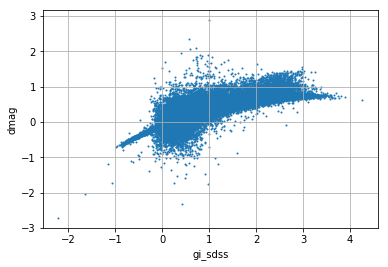

In [17]:
band in bandList[0]
magName = band
magName_match = matchBand_dict[band]
color_name_1 = color_name_1_dict[band]
colorLabel_1 = colorLabel_1_dict[band]

df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]
df.plot(color_name_1,'dmag', kind='scatter', grid=True, s=1.0)

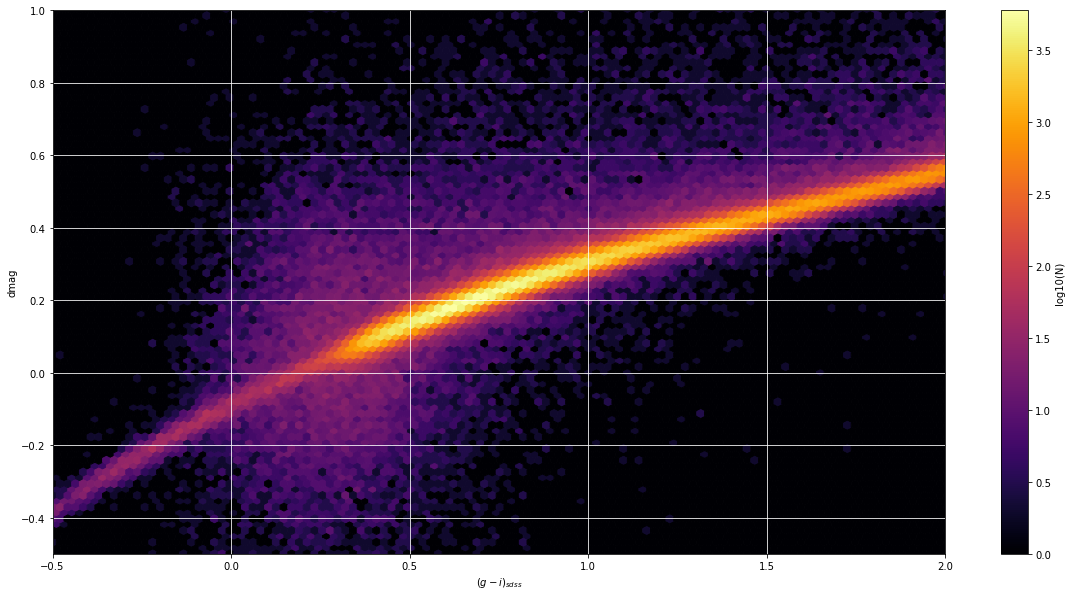

In [18]:
fig = plt.figure(figsize=(20,10))
hb=plt.hexbin(df.loc[:, color_name_1].values, df.loc[:,'dmag'].values, \
                  gridsize=300, bins='log', cmap='inferno')
#hb=plt.hexbin(df.loc[:, color_name_1].values, df.loc[:,'dmag'].values, \
#                  gridsize=300, cmap='inferno')
ax=plt.axis([-0.5, 2.0, -0.5, 1.0])
plt.xlabel(colorLabel_1)
plt.ylabel('dmag')
cb = fig.colorbar(hb)
#cb.set_label('Number')
cb.set_label('log10(N)')
plt.grid(color='white')
plt.grid(True)

## Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
G_gaia
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count     50721.000000
mean          0.808503
std           0.255265
min          -0.495221
0.01%        -0.367543
50%           0.764324
99.99%        2.088335
max           2.375071
Name: gi_sdss, dtype: float64
-0.4 2.1

[-4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
 -1.11022302e-16  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00
  2.00000000e+00  2.10000000e+00]
[-0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75
  0.85  0.95  1.05  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95
  2.05]

     gi_sdss bin_interval bin_l

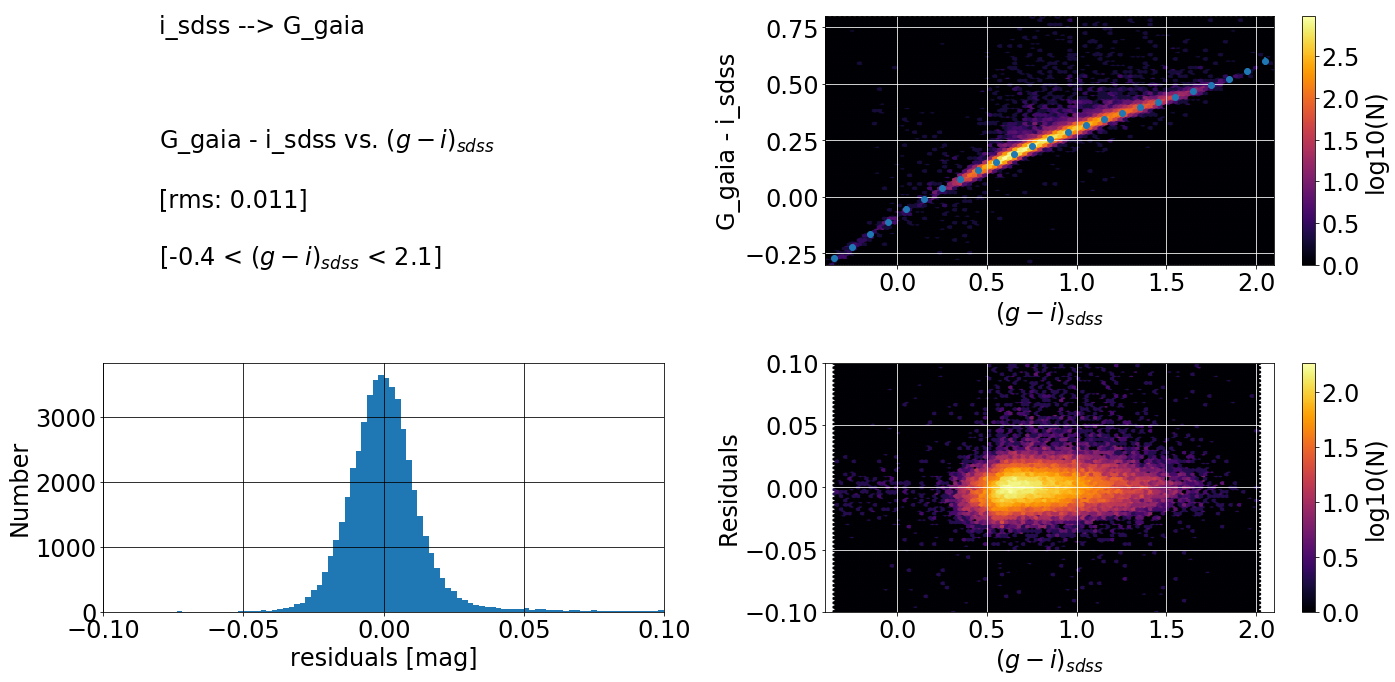

In [19]:
for band in bandList:
    
    print 
    print 
    print 
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print band
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print 
    
    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) )
    mask = mask & mask1 & mask2

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag and color1 series...
    dmag =  df.loc[:,'dmag']
    color1 = df.loc[:,color_name_1]


    # Calculate the color range to bin and the number of bins, 
    #  based on the 0.01%-99.99% color range...
    color1_desc = df[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*color1_desc['0.01%'])/10.
    color1_max = math.ceil(10*color1_desc['99.99%'])/10.
    if verbose>1:
        print 
        print color1_desc
        print color1_min, color1_max 
        print 
    binsize = color_binsize
    ranges = np.arange(color1_min,color1_max+binsize,binsize)
    # Label the bins by their mid-point...
    labels = np.arange(color1_min,color1_max,binsize) + 0.5*binsize
    
    #nbins = int((color1_max-color1_min)/binsize)+1
    #ranges = np.linspace(color1_min, color1_max, nbins+1)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins) + 0.5*binsize

    #nbins = math.floor((color1_max-color1_min)/binsize) + 1
    #ranges = np.linspace(color1_min, color1_max, nbins)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins-1) + 0.5*binsize
    
    if verbose:
        print ranges
        print labels
    
    # Bin the data, adding "bin_interval" and "bin_label' to the df dataframe...
    df['bin_interval'] = pd.cut(df[color_name_1], bins=ranges, precision=0)
    df['bin_label'] = pd.cut(df[color_name_1], bins=ranges, labels=labels)
    if verbose>1:
        print 
        print df[[color_name_1,'bin_interval','bin_label']].head()
        print 

    # Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
    df_grp = df.groupby(['bin_label'])
    bin_interval = df_grp['bin_interval'].first()
    dmag_num = df_grp['dmag'].count()
    dmag_mean = df_grp['dmag'].mean()
    dmag_sd = df_grp['dmag'].std()
    dmag_err = dmag_sd/np.sqrt(dmag_num-1)
    dmag_median = df_grp['dmag'].median()
    dmag_rsd = df_grp['dmag'].apply(robustStdDev)
    dmag_unc = np.sqrt(np.pi/2)*dmag_rsd/np.sqrt(dmag_num)

    # Rename some of the pandas series...
    dmag_num.name    = 'bin_num'
    dmag_mean.name   = 'bin_mean'
    dmag_sd.name     = 'bin_stddev'
    dmag_err.name    = 'bin_stderr'
    dmag_median.name = 'bin_median'
    dmag_rsd.name    = 'bin_rstddev'
    dmag_unc.name    = 'bin_unc'
    
    # Create new data frame containing all the relevant aggregate quantities...
    df1 = pd.concat( [bin_interval, dmag_num, \
                      dmag_mean, dmag_sd, dmag_err, \
                      dmag_median, dmag_rsd, dmag_unc, ], \
                    join='outer', axis=1 )
    
    if verbose>1:
        print 
        print df1
        print 
    
    
    # Create results output file...
    resultsFile = """%s.%s_%s.csv""" % (resultsFileBaseName, band, color_name_1)
    df1.to_csv(resultsFile)
    if verbose>1:
        print """Writing binned values to %s""" % (resultsFile)

    
    # Create name for QA plot output file...
    outputFileName = """qaPlot_%s.%s_%s.png""" % (resultsFileBaseName, band, color_name_1)

    # Create title and labels for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagLabel = """%s - %s""" % (magName, magName_match)


    # Create QA plots...
    status = interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                                     title, dmagLabel, outputFileName, verbose)
    
    

In [20]:
%ls -FlthrG

total 16G
-rwxr-xr-x 1 dtucker   45K Jun 13  2018 sdss_des_transform.py*
-rw-rw-r-- 1 dtucker 1023M Nov 17  2020 y6a2_stripe82area_stars_000001.fits
-rw-rw-r-- 1 dtucker 1023M Nov 17  2020 y6a2_stripe82area_stars_000002.fits
-rw-rw-r-- 1 dtucker  204M Nov 17  2020 y6a2_stripe82area_stars_000003.fits
-rw-rw-r-- 1 dtucker   275 Nov 17  2020 y6a2_stripe82area_stars.sql
-rw-rw-r-- 1 dtucker  2.2G Nov 17  2020 y6a2_stripe82area_stars.fits
-rw-rw-r-- 1 dtucker  872M Nov 17  2020 match_y6a2_stripe82area_stars_SDSSDR13.fits
-rw-rw-r-- 1 dtucker  2.0G Nov 17  2020 match_y6a2_stripe82area_stars_PS1DR2.fits
-rw-rw-r-- 1 dtucker  2.5M Nov 18  2020 temp.csv
-rw-rw-r-- 1 dtucker  620K Nov 19  2020 TransformationEquations_DES_DR2_SDSS_DR13_orig.ipynb
-rw-rw-r-- 1 dtucker   83K Nov 20  2020 plot.uNUV.NUVg.qa1.png
-rw-rw-r-- 1 dtucker   83K Nov 20  2020 qaPlot.ps1_to_des.dmag_g.$(g-i)_{ps1}$.qa1.png
-rw-rw-r-- 1 dtucker   83K Nov 20  2020 qaPlot.ps1_to_des.dmag_g.gi_ps1.qa1.png
-rw-rw-r-- 1 dtucker   8

In [21]:
#%pwd